# Exercise 4: recommender System

In [1]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


## Code from the lecture

In [2]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [3]:
def getTopN(movie_id,D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [14]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
#Geht alle ratings durch. Und füllt die Matrix an der Stelle [User_id][0]= Yakup und [movie_id][0]= Pulp Fiction mit dem entsprechendem Rating Was Yakup gab.
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1] = ratings['rating'][i]

In [15]:
import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [16]:
import scipy.spatial
#PDist m(Zeilen)*n(Spalten) Matrix R= m(User), n(Movies); R.T= m(Movies) n(user)
#Sonst würde man bei der Distanz berechnung zwischen den selben Movie 
#Die Squarform: Jede Zeile (Movie) in R wird seq. mit den anderen Zeilen dist berechnet.
#Zeil0 mit Zeile0 (sich selbst) ergibt in eD(Zeile00); Z0 mit Z1 ergibt eD(Z01) usw.
eD = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T,metric='euclidean'))
#Da Cos(0)=1 Ähnlich. ändern wir die ausgabe. Alles -1 -> Dann ist alles null Ähnlich. Mit Abs machen wir dann Positiv
#Heißt alles was jetzt von Null wegläuft ist weniger ähnlich.
# Das selbe muss bei Euklid gemacht werden. Hier ist bereits 0 Ähnlich. Aber wir wissen keine Information über ähnlichkeit
# Nehmen Das Max entfernte Distanz und subtrahieren es überall. Dadurch das am weitesen entfernte objekt 0
# das am nächsten die größte Zahl. 
eD= np.abs(np.nan_to_num(eD-np.max(eD)))
# Diag voll mit Hoher Zahl, da sich selbs wieder auf null hauen.
np.fill_diagonal(eD,0)# CosDist: 1 Ähnlich Euklid: 0 Ähnlich


In [17]:
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)
D_train=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='cosine'))
eD_train=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='euclidean'))
# Numpy rechnung 1-CosD -> Die 1 rausbekommen. Dann wieder 1 Ähnlich 0 nicht ähnlich aber diag wieder null setzten!
D_train=np.abs(np.nan_to_num( D_train-1))
eD_train=np.abs(np.nan_to_num( eD_train-eD_train.max()))
np.fill_diagonal(D_train,0)
np.fill_diagonal(eD_train,0)

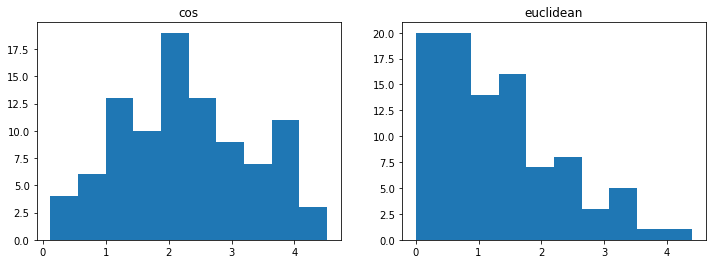

In [18]:
test_resultD = test_Score(D_train, R_test)
test_resulteD = test_Score(eD_train, R_test)

fig=plt.figure(figsize=(12, 4))
ax1=fig.add_subplot(1, 2, 1)
ax1.title.set_text('cos')
plt.hist(test_resultD)
ax2= fig.add_subplot(1, 2, 2)
ax2.title.set_text('euclidean')
plt.hist(test_resulteD)
plt.show()

In [19]:
print('Cos:', np.mean(test_resultD))
print('Euclidean:', np.mean(test_resulteD))

Cos: 2.2698947368421054
Euclidean: 1.2892631578947367


## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

In [64]:
def getBest5(D):
    #summiere alle Ratings eines Films
    sumRatings = np.sum(D,axis=0)
    #Sotiere aufsteigend die Filme nach sumRatings
    return np.argsort(sumRatings)[-5:] 

def getRand5(D):
    return np.random.randint(np.shape(D)[0], size=5)

# re implement  eval functions to allow different rankings
def Score_byID(ID, D, Test, f): #f ist the ranking function
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = f(ID,D)[::-1]
    res_title = getNameByID(f(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test,f = getTopN): #f ist the ranking function -> function as argument Falls kein argument defaul getTopN
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i],f)
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

Best of 5: 1.745263157894737
Rand of 5: 0.22947368421052633
Cos 2.2698947368421054


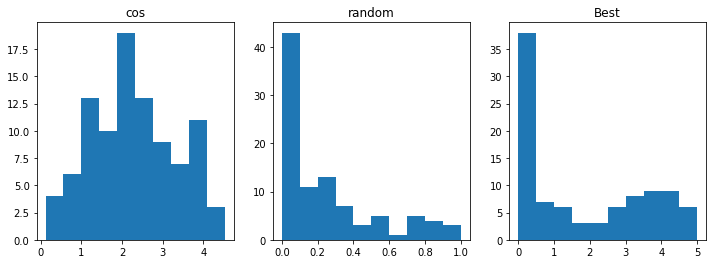

In [51]:
testResultBest = test_Score(D_train, R_test, getBest5)
testResultRand = test_Score(D_train, R_test, getRand5)

print('Best of 5:', np.mean(testResultBest))
print('Rand of 5:', np.mean(testResultRand))
print('Cos', np.mean(test_resultD))

fig=plt.figure(figsize=(12, 4))
ax1=fig.add_subplot(1, 3, 1)
ax1.title.set_text('cos')
plt.hist(test_resultD)
ax2= fig.add_subplot(1, 3, 2)
ax2.title.set_text('random')
plt.hist(testResultRand)
ax2= fig.add_subplot(1, 3, 3)
ax2.title.set_text('Best')
plt.hist(testResultBest)
plt.show()

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$


In [52]:
u, s, vh = np.linalg.svd(R_train, full_matrices=True)

In [55]:
u.shape, s.shape, vh.shape

((848, 848), (848,), (1682, 1682))

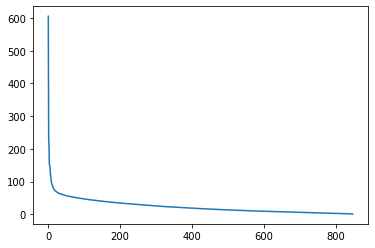

In [56]:
plt.plot(s)

In [59]:
np.allclose(R_train, np.dot(u * s, vh[:848,:]))

True

In [60]:
cut = 10 #select how many dims we want to keep
R_approx = np.dot(u[:,:cut] * s[:cut], vh[:cut,:])

In [61]:
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

D_approx=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_approx.T, metric='cosine'))
D_approx=np.abs(np.nan_to_num( D_approx-1)) #dist to similarity 
np.fill_diagonal(D_approx,0) #set self-dist to zero

In [65]:
test_approx=test_Score(D_approx,R_test)

In [67]:
print("Mean scores on test: full cos:",np.mean(test_resultD), "approx cos:",np.mean(test_approx))

Mean scores on test: full cos: 2.2698947368421054 approx cos: 1.711578947368421


(array([ 6., 15., 18., 20.,  9., 14.,  4.,  5.,  3.,  1.]),
 array([0.   , 0.452, 0.904, 1.356, 1.808, 2.26 , 2.712, 3.164, 3.616,
        4.068, 4.52 ]),
 <a list of 10 Patch objects>)

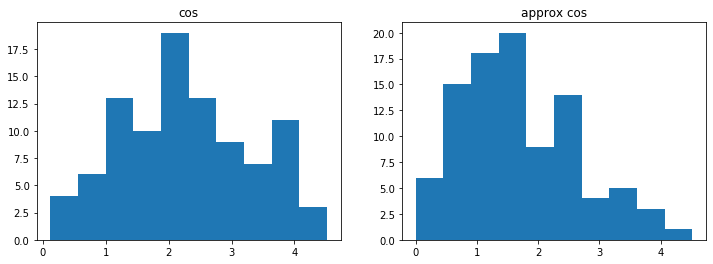

In [69]:
fig=plt.figure(figsize=(12, 4))
ax1=fig.add_subplot(1, 2, 1)
ax1.title.set_text('cos')
plt.hist(test_resultD)
ax2= fig.add_subplot(1, 2, 2)
ax2.title.set_text('approx cos')
plt.hist(test_approx)